### Predicting Potential Rock Glaciers in Eastern Anatolia Mountains

### Problem Definition: 
In the context of a worldwide project, GLIMS, ice, icecaps and rock glaciers are recorded all around the world including Turkey. Rock glaciers are located remote high mountains of Anatolian peninsula. Rock glaciers in GLIMS dataset are detected by human eye and mostly they are very well documented in old geography books. In this study very high resolution satellite imagery (Google Maps) were examined and Rock Glaciers like geographical objects were detected. In the second step a database was created for existing and potential rock glaciers.  

### Data

Four different excel tables were used as data in this study:
    <p>1- glims_tr_parameters: This table has information about existing rock glaciers in Turkey.</p>
    <p>2- possibleRG_parameters: This table has information about potential rock glaciers in Turkey.</p>
    <p>3- random_points_parameters: A set of random points generated and attribute information was produced for these points. These random points were used as places where there is no rock glacier. In other word these points represent "0" class values geographical objects.</p>
    <p>4- data: This table is the combination of glims_tr_parameters table and random_points_parameters. By combination of these tables, a data frame which has both "0" and "1" values in the "Class" columns was created.</p>

### Attribute Information

<p>X, Y: Cartesian coordinate values of points. Generated by ArcGIS Pro on a map with WGS Web Mercator (auxiliary sphere) projection.</p>
<p>Altitude: This information was directly taken from a Digital Elevation Model (DEM) probided by ASTER sensor of Terra satellite.</p>
<p>Aspect: Aspect values were produced by ArcGIS Pro from ASTER-DEM data. Aspect directions replaced with numbers and converted to categorical values at the end.</p>
<p> N=1, NE=2, E=3, SE=4, S=5, SW=6, W=7, NW=8, Flat=9.</p>
<p>Curvature: Curvature values were produced by ArcGIS Pro from ASTER-DEM data.</p>
<p>Land surface temperature (LST): LST values were produced by ArcGIS Pro from ASTER-DEM data.</p>
<p>Slope: Slope values were produced by ArcGIS Pro from ASTER-DEM data.</p>
<p>Solar radiation: Solar radiation values were produced by ArcGIS Pro from ASTER-DEM data.</p>
<p>Snow Water Equivalent (SWE): This data was taken from ESA's website.</p>
<p>Topographic Wetness Index (TWI): TWI values were produced by ArcGIS Pro from ASTER-DEM data.</p>

### Importing Libraries and Tools

In [1]:
# For exploratory data analysis (EDA) and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Models 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
import sklearn.metrics as metrics

### Loading data tables

In [2]:
glims = pd.read_excel("glims_tr_parameters.xls")
randomp = pd.read_excel("random_points_parameters.xls")
possibleRG = pd.read_excel("possibeRG_parameters.xls")
df = pd.read_excel("data.xls")

"df" object is a combination of the 

In [3]:
df.head(10)

,X,Y,Altitude,Aspect,Curvature,LST,Slope,Solar_Radiation,SWE,Wetness,Class
0,3.945608e+06,4.655139e+06,3528,1,-4.304350,9.958840,55.004200,525806,-2.0,NaN,1
1,4.354596e+06,4.790086e+06,2896,1,-13.374200,7.907170,66.352203,639952,-2.0,4.81096,1
2,4.355264e+06,4.789941e+06,2963,1,1.229810,3.760770,26.342699,768184,-2.0,NaN,1
3,4.356600e+06,4.792826e+06,2926,1,-0.614907,7.096090,41.633301,409747,-2.0,8.26932,1
4,4.373520e+06,4.787202e+06,2906,8,-2.767080,16.697399,27.077801,1150113,-2.0,5.51924,1
5,4.373854e+06,4.788067e+06,2844,8,-2.767080,13.290400,18.773399,933716,-2.0,8.94292,1
6,4.374299e+06,4.788211e+06,2829,2,-1.690990,11.285400,20.081301,930679,-2.0,4.24515,1
7,4.374633e+06,4.788355e+06,2821,8,-1.383540,9.567710,15.126500,1045642,-2.0,NaN,1
8,4.375079e+06,4.787778e+06,3035,2,-4.150620,17.157600,30.185900,1200576,-2.0,4.47385,1
9,4.375079e+06,4.788355e+06,3072,8,3.228260,15.149100,43.827202,984870,-2.0,5.84478,1


In [4]:
# Number of positive (1) and negative (0) in the dataframe
df.Class.value_counts()

0    84
1    51
Name: Class, dtype: int64

In [5]:
# Normalized value counts
df.Class.value_counts(normalize=True)

0    0.622222
1    0.377778
Name: Class, dtype: float64

The dataset can be considered as balanced due to number of samples in 'Class' attribute.

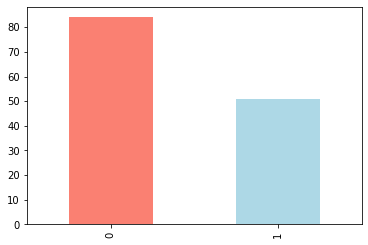

In [6]:
# Plotting number of values in Class column
df.Class.value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   X                135 non-null    float64
 1   Y                135 non-null    float64
 2   Altitude         135 non-null    int64  
 3   Aspect           135 non-null    int64  
 4   Curvature        135 non-null    float64
 5   LST              135 non-null    float64
 6   Slope            135 non-null    float64
 7   Solar_Radiation  135 non-null    int64  
 8   SWE              135 non-null    float64
 9   Wetness          89 non-null     float64
 10  Class            135 non-null    int64  
dtypes: float64(7), int64(4)
memory usage: 11.7 KB


In [8]:
df["Altitude"] = df["Altitude"].astype(float)
df["Solar_Radiation"] = df["Solar_Radiation"].astype(float)
df["SWE"] = df["SWE"].astype(float)

In [9]:
#Checking null values in the dataframe
df.isna().sum()

X                   0
Y                   0
Altitude            0
Aspect              0
Curvature           0
LST                 0
Slope               0
Solar_Radiation     0
SWE                 0
Wetness            46
Class               0
dtype: int64

In [10]:
# I prefer replace null values with the column mean
df.fillna(df.mean(), inplace=True)

In [11]:
df.describe()

,X,Y,Altitude,Aspect,Curvature,LST,Slope,Solar_Radiation,SWE,Wetness,Class
count,1.350000e+02,1.350000e+02,135.000000,135.000000,135.000000,135.000000,135.000000,1.350000e+02,135.000000,135.000000,135.000000
mean,4.661727e+06,4.723203e+06,2618.370370,3.807407,-0.314286,24.841096,25.660635,1.263511e+06,-1.885427,6.084566,0.377778
std,2.236674e+05,1.965222e+05,698.425433,2.454044,2.190659,11.013751,10.749633,3.104999e+05,1.331222,1.584668,0.486637
min,3.945608e+06,4.448339e+06,799.000000,1.000000,-13.374200,-0.999959,1.586640,4.097470e+05,-2.000000,3.553320,0.000000
25%,4.418994e+06,4.511066e+06,2215.500000,2.000000,-1.152950,15.763200,18.748000,1.052516e+06,-2.000000,5.248670,0.000000
50%,4.628787e+06,4.786193e+06,2737.000000,3.000000,-0.153727,25.800000,25.638399,1.301006e+06,-2.000000,6.084566,0.000000
75%,4.895386e+06,4.831342e+06,3094.500000,6.000000,0.768634,33.387350,31.608900,1.490298e+06,-2.000000,6.301085,1.000000
max,4.955160e+06,5.069483e+06,4850.000000,8.000000,5.226710,46.906200,66.352203,1.871867e+06,13.467400,11.882200,1.000000


In [12]:
# Compare target column with sex column
pd.crosstab(df.Class, df.Aspect)

Aspect,1,2,3,4,5,6,7,8
Class,,,,,,,,
0,11,12,10,16,8,11,12,4
1,20,13,5,0,0,0,2,11


This small table indicates positive values accumulate on northern sides and there is no positive value on southern sides of mountains.

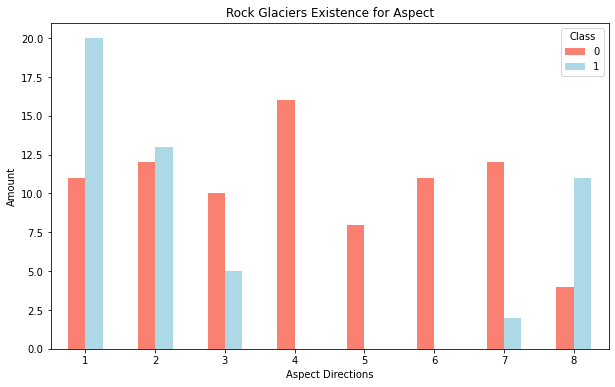

In [13]:
# Create a plot
pd.crosstab(df.Aspect, df.Class).plot(kind="bar", figsize=(10,6), color=["salmon", "lightblue"])
plt.title("Rock Glaciers Existence for Aspect")
plt.xlabel("Aspect Directions")
plt.ylabel("Amount")
#plt.legend(["Female", "Male"])
plt.xticks(rotation=0); # keep the labels on the x-axis vertical

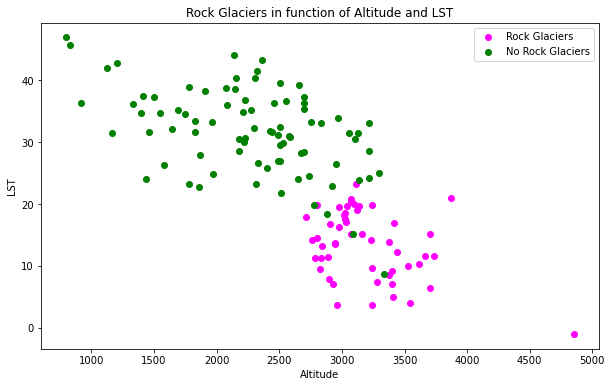

In [14]:
# Representing Rock Glaciers on Altitude-LST axes
plt.figure(figsize=(10,6))

# Positive samples
plt.scatter(df.Altitude[df.Class==1], df.LST[df.Class==1], c="magenta") 

# Negative samples
plt.scatter(df.Altitude[df.Class==0], df.LST[df.Class==0], c="green") 

plt.title("Rock Glaciers in function of Altitude and LST")
plt.xlabel("Altitude")
plt.ylabel("LST")
plt.legend(["Rock Glaciers", "No Rock Glaciers"]);

According to this figure land surface temperature and altitude features are very decisive for existince of rock glaciers. Basically rock glaciers exist where altitude is high and LST is relatively low.

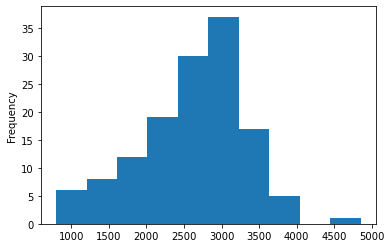

In [15]:
# Checking attribute values by histogram
df.Altitude.plot.hist();

In [16]:
# I drop Class column and made a dataframe for independent variables
df_ind = df.drop(['Aspect','Class'], axis=1)

In [17]:
df_ind

,X,Y,Altitude,Curvature,LST,Slope,Solar_Radiation,SWE,Wetness
0,3.945608e+06,4.655139e+06,3528.0,-4.304350,9.958840,55.004200,525806.0,-2.0,6.084566
1,4.354596e+06,4.790086e+06,2896.0,-13.374200,7.907170,66.352203,639952.0,-2.0,4.810960
2,4.355264e+06,4.789941e+06,2963.0,1.229810,3.760770,26.342699,768184.0,-2.0,6.084566
3,4.356600e+06,4.792826e+06,2926.0,-0.614907,7.096090,41.633301,409747.0,-2.0,8.269320
4,4.373520e+06,4.787202e+06,2906.0,-2.767080,16.697399,27.077801,1150113.0,-2.0,5.519240
...,...,...,...,...,...,...,...,...,...
130,4.511517e+06,4.943301e+06,2967.0,0.922360,33.881802,25.535900,1751206.0,-2.0,5.923460
131,4.605346e+06,5.018597e+06,2949.0,0.307453,26.513700,31.589001,1803093.0,-2.0,3.725110
132,4.560825e+06,4.973993e+06,3293.0,0.000000,25.061399,20.436701,1860824.0,-2.0,4.919200
133,4.927690e+06,4.818676e+06,3216.0,-0.614907,33.012901,22.926901,1867369.0,-2.0,5.708770


In [18]:
# Correlation between independent variables
corr_matrix = df_ind.corr()
corr_matrix

,X,Y,Altitude,Curvature,LST,Slope,Solar_Radiation,SWE,Wetness
X,1.000000,-0.680552,-0.217496,0.234065,0.278417,-0.277835,0.251408,-0.114430,0.004057
Y,-0.680552,1.000000,0.202621,-0.081974,-0.201321,0.269357,-0.000955,0.025262,-0.115059
Altitude,-0.217496,0.202621,1.000000,-0.099974,-0.730613,0.208950,-0.075816,-0.138472,-0.122986
Curvature,0.234065,-0.081974,-0.099974,1.000000,0.144726,-0.237932,0.287518,0.055033,-0.048327
LST,0.278417,-0.201321,-0.730613,0.144726,1.000000,-0.248546,0.397024,0.097766,0.053500
Slope,-0.277835,0.269357,0.208950,-0.237932,-0.248546,1.000000,-0.431444,0.024590,-0.263778
Solar_Radiation,0.251408,-0.000955,-0.075816,0.287518,0.397024,-0.431444,1.000000,-0.024601,0.003477
SWE,-0.114430,0.025262,-0.138472,0.055033,0.097766,0.024590,-0.024601,1.000000,-0.046912
Wetness,0.004057,-0.115059,-0.122986,-0.048327,0.053500,-0.263778,0.003477,-0.046912,1.000000


<AxesSubplot:>

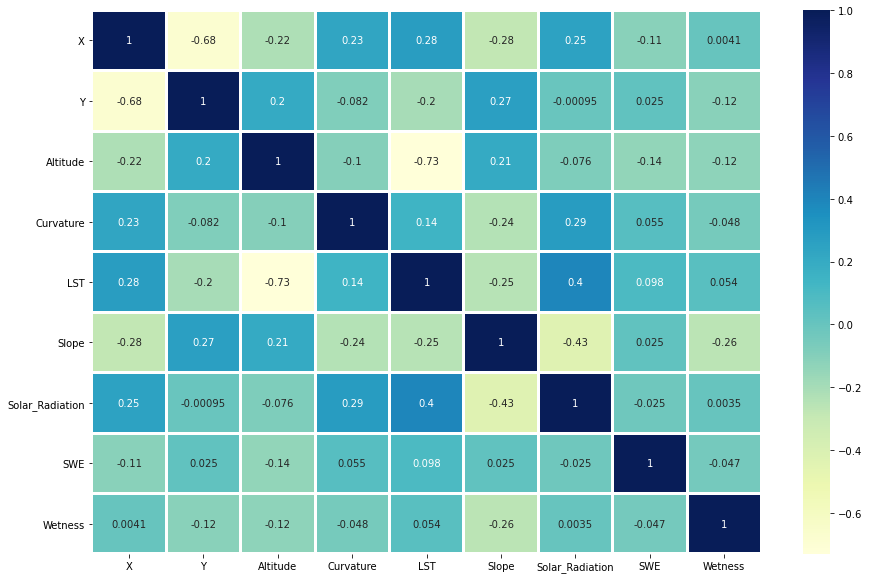

In [19]:
# Plotting correlation matrix of numeric attributes in the dataset
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.heatmap(df_ind.corr(),cmap="YlGnBu",ax=ax,annot=True,linewidths=2)

Correlation between independent variables are very low and this might affect classification in a positive way. Because this low coefficiency indicates that there is no multi-collinearity and no need to eliminate any of features.

# Modeling

The purpose of this study is to discover new rock glaciers in high mountains of Turkey. Machine learning methods will be used as tools for this purpose.
First the data will be prepared for classification.

In [20]:
df.head()

,X,Y,Altitude,Aspect,Curvature,LST,Slope,Solar_Radiation,SWE,Wetness,Class
0,3.945608e+06,4.655139e+06,3528.0,1,-4.304350,9.958840,55.004200,525806.0,-2.0,6.084566,1
1,4.354596e+06,4.790086e+06,2896.0,1,-13.374200,7.907170,66.352203,639952.0,-2.0,4.810960,1
2,4.355264e+06,4.789941e+06,2963.0,1,1.229810,3.760770,26.342699,768184.0,-2.0,6.084566,1
3,4.356600e+06,4.792826e+06,2926.0,1,-0.614907,7.096090,41.633301,409747.0,-2.0,8.269320,1
4,4.373520e+06,4.787202e+06,2906.0,8,-2.767080,16.697399,27.077801,1150113.0,-2.0,5.519240,1


In [21]:
# Splitting target variable
# Everything except target variable
X = df.drop("Class", axis=1)

# Target variable
y = df.Class.values

In [22]:
# Independent variables
X.head(10)

,X,Y,Altitude,Aspect,Curvature,LST,Slope,Solar_Radiation,SWE,Wetness
0,3.945608e+06,4.655139e+06,3528.0,1,-4.304350,9.958840,55.004200,525806.0,-2.0,6.084566
1,4.354596e+06,4.790086e+06,2896.0,1,-13.374200,7.907170,66.352203,639952.0,-2.0,4.810960
2,4.355264e+06,4.789941e+06,2963.0,1,1.229810,3.760770,26.342699,768184.0,-2.0,6.084566
3,4.356600e+06,4.792826e+06,2926.0,1,-0.614907,7.096090,41.633301,409747.0,-2.0,8.269320
4,4.373520e+06,4.787202e+06,2906.0,8,-2.767080,16.697399,27.077801,1150113.0,-2.0,5.519240
5,4.373854e+06,4.788067e+06,2844.0,8,-2.767080,13.290400,18.773399,933716.0,-2.0,8.942920
6,4.374299e+06,4.788211e+06,2829.0,2,-1.690990,11.285400,20.081301,930679.0,-2.0,4.245150
7,4.374633e+06,4.788355e+06,2821.0,8,-1.383540,9.567710,15.126500,1045642.0,-2.0,6.084566
8,4.375079e+06,4.787778e+06,3035.0,2,-4.150620,17.157600,30.185900,1200576.0,-2.0,4.473850
9,4.375079e+06,4.788355e+06,3072.0,8,3.228260,15.149100,43.827202,984870.0,-2.0,5.844780


In [23]:
# Target variable
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

### Train/Test Split

In [24]:
# Random seed for reproducibility
np.random.seed(25)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33) 

In [25]:
X_train.head()

,X,Y,Altitude,Aspect,Curvature,LST,Slope,Solar_Radiation,SWE,Wetness
102,4.951076e+06,4.478082e+06,1781.0,6,0.153727,38.916302,24.369600,1481941.0,-2.0,5.822540
111,4.946352e+06,4.458989e+06,1548.0,5,-1.690990,34.638901,23.564199,1536605.0,-2.0,11.882200
65,4.628787e+06,5.033248e+06,1963.0,7,1.690990,33.200000,37.508400,1098546.0,-2.0,6.084566
81,4.915623e+06,4.500915e+06,2078.0,3,-0.922360,38.677502,26.975201,1312323.0,-2.0,5.705980
90,4.421338e+06,4.816214e+06,1162.0,4,-0.153727,31.494801,12.171800,1414189.0,-2.0,6.084566


In [26]:
y_train, len(y_train)

(array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0], dtype=int64),
 90)

In [27]:
X_test.head()

,X,Y,Altitude,Aspect,Curvature,LST,Slope,Solar_Radiation,SWE,Wetness
67,4.945183e+06,4.490674e+06,1830.0,2,0.000000,33.490299,25.737101,1127918.0,-2.0,6.084566
106,4.612085e+06,5.023113e+06,2670.0,3,0.922360,28.241301,31.628799,1508235.0,-2.0,5.802990
127,4.769225e+06,4.596709e+06,2555.0,5,0.614907,36.660301,34.161400,1705019.0,-2.0,6.111480
131,4.605346e+06,5.018597e+06,2949.0,5,0.307453,26.513700,31.589001,1803093.0,-2.0,3.725110
26,4.419161e+06,4.793980e+06,3122.0,8,-2.920810,18.962099,21.843500,1410688.0,-2.0,6.792100


In [28]:
y_test, len(y_test)

(array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        0], dtype=int64),
 45)

## Model Selection

<p>Four different models will be used for binary classification in this study:</p>
    <p>1- Logistic Regression</p>
    <p>2- K-Nearest Neighbors</p>
    <p>3- Random Forest</p>
    <p>4- Artificial Neural Network</p>
    

In [29]:
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier()}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(25)
    model_scores = {}
    for name, model in models.items():
        # Fitting the models
        model.fit(X_train, y_train)
        # Evaluating model scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [30]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

{'KNN': 0.6888888888888889,
 'Logistic Regression': 0.9333333333333333,
 'Random Forest': 0.9777777777777777}

### Model Comparison

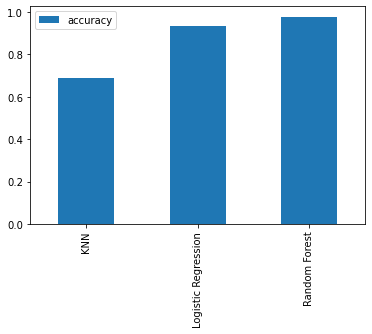

In [31]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar();

## Tuning K-Nearest Neighbors by hand

In [32]:
train_scores = []
test_scores = []
neighbors = range(1, 21) 
knn = KNeighborsClassifier()
for i in neighbors:
    knn.set_params(n_neighbors = i) 
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

In [33]:
train_scores

[1.0,
 0.8666666666666667,
 0.8444444444444444,
 0.8333333333333334,
 0.8333333333333334,
 0.8111111111111111,
 0.7777777777777778,
 0.7888888888888889,
 0.8111111111111111,
 0.7333333333333333,
 0.7333333333333333,
 0.7444444444444445,
 0.7111111111111111,
 0.7444444444444445,
 0.7444444444444445,
 0.7444444444444445,
 0.7555555555555555,
 0.7555555555555555,
 0.7555555555555555,
 0.7555555555555555]

Maximum KNN score on the test data: 80.00%


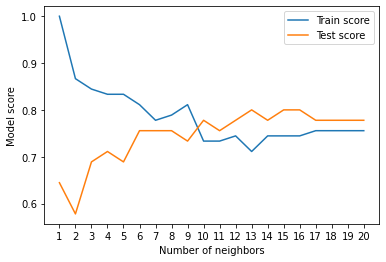

In [34]:
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

KNN did not provide accuracy as much as Logistic Regression and Random Forest. Therefore I will try to tune it.

In [35]:
# Creating hyperparameter grid
# LogisticRegression hyperparameters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [36]:
# Tuning with randomized search
np.random.seed(25)
# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)
# Fit random hyperparameter search model
rs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [37]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.0001}

In [38]:
rs_log_reg.score(X_test, y_test)

0.9333333333333333

In [39]:
# RandomizedSearchCV - tries n_iter combinations of hyperparameters and saves the best.
# GridSearchCV - tries every single combination of hyperparameters and saves the best.

In [40]:
# Tuning with grid search
# Different LogisticRegression hyperparameters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}
# Setup grid hyperparameter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)
# Fit grid hyperparameter search model
gs_log_reg.fit(X_train, y_train);

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [41]:
# Check the best parameters
gs_log_reg.best_params_

{'C': 0.0001, 'solver': 'liblinear'}

In [42]:
# Evaluate the model
gs_log_reg.score(X_test, y_test)

0.9333333333333333

### Evaluating tuned KNN Model

<p>These metrics will be used for evaluation of models:</p>
    <p>* ROC curve and AUC score</p>
    <p>* Confusion matrix</p>
    <p>* Classification report</p> 
    <p>* Precision</p> 
    <p>* Recall</p>
    <p>* F1-score</p> 

In [43]:
# Making preidctions on test data
y_preds = gs_log_reg.predict(X_test)
y_preds

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0], dtype=int64)

In [44]:
# Lets check y_test
y_test

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0], dtype=int64)

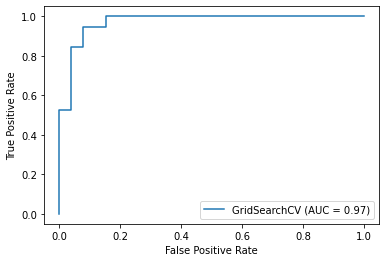

In [45]:
# Creating ROC Curve
from sklearn.metrics import plot_roc_curve
plot_roc_curve(gs_log_reg, X_test, y_test);

In [46]:
# Confusion matrix
print(confusion_matrix(y_test, y_preds))

[[24  2]
 [ 1 18]]


In [47]:
# Classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        26
           1       0.90      0.95      0.92        19

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.93        45
weighted avg       0.93      0.93      0.93        45



### Evaluation with cross-validation 

In [48]:
# Checking best hyperparameters
gs_log_reg.best_params_

{'C': 0.0001, 'solver': 'liblinear'}

In [49]:
from sklearn.model_selection import cross_val_score

# Instantiate best model with best hyperparameters (found with GridSearchCV)
clf = LogisticRegression(C=0.0001, solver="liblinear")

In [50]:
# Cross-validated accuracy score
cv_acc = cross_val_score(clf, X, y, cv=5, scoring="accuracy") 
cv_acc

array([0.74074074, 0.81481481, 0.96296296, 0.96296296, 0.96296296])

In [51]:
cv_acc = np.mean(cv_acc)
cv_acc

0.8888888888888887

In [52]:
# Cross-validated precision score
cv_precision = np.mean(cross_val_score(clf, X, y, cv=5, scoring="precision")) 
cv_precision

0.8595959595959595

In [53]:
# Cross-validated recall score
cv_recall = np.mean(cross_val_score(clf, X, y, cv=5, scoring="recall"))
cv_recall

0.9

In [54]:
# Cross-validated F1 score
cv_f1 = np.mean(cross_val_score(clf, X, y, cv=5, scoring="f1"))
cv_f1

0.8685161178809093

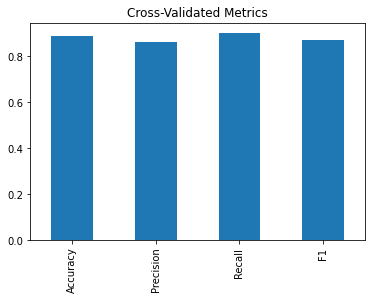

In [55]:
# Visualizing cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                            "Precision": cv_precision,
                            "Recall": cv_recall,
                            "F1": cv_f1},
                          index=[0])
cv_metrics.T.plot.bar(title="Cross-Validated Metrics", legend=False);

In [56]:
X.shape

(135, 10)

In [57]:
# first neural network with keras tutorial
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

In [58]:
# define the keras model
np.random.seed(25)
model = Sequential()
model.add(Dense(12, input_dim=10, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X, y, epochs=380, batch_size=100)

Epoch 1/380
2/2 [==============================] - 0s 1ms/step - loss: 477982.0312 - accuracy: 0.3778
Epoch 2/380
2/2 [==============================] - 0s 2ms/step - loss: 450022.6250 - accuracy: 0.3778
Epoch 3/380
2/2 [==============================] - 0s 998us/step - loss: 424936.9688 - accuracy: 0.3778
Epoch 4/380
2/2 [==============================] - 0s 2ms/step - loss: 401316.2188 - accuracy: 0.3778
Epoch 5/380
2/2 [==============================] - 0s 970us/step - loss: 377831.3438 - accuracy: 0.3778
Epoch 6/380
2/2 [==============================] - 0s 2ms/step - loss: 355660.5312 - accuracy: 0.3778
Epoch 7/380
2/2 [==============================] - 0s 2ms/step - loss: 334037.9375 - accuracy: 0.3778
Epoch 8/380
2/2 [==============================] - 0s 997us/step - loss: 312346.3125 - accuracy: 0.3778
Epoch 9/380
2/2 [==============================] - 0s 2ms/step - loss: 290861.2500 - accuracy: 0.3778
Epoch 10/380
2/2 [==============================] - 0s 997us/step - loss: 26

2/2 [==============================] - 0s 2ms/step - loss: 14506.8164 - accuracy: 0.6889
Epoch 81/380
2/2 [==============================] - 0s 2ms/step - loss: 14451.2334 - accuracy: 0.6889
Epoch 82/380
2/2 [==============================] - 0s 998us/step - loss: 14391.3633 - accuracy: 0.6889
Epoch 83/380
2/2 [==============================] - 0s 997us/step - loss: 14367.7998 - accuracy: 0.6963
Epoch 84/380
2/2 [==============================] - 0s 2ms/step - loss: 14290.0850 - accuracy: 0.6963
Epoch 85/380
2/2 [==============================] - 0s 997us/step - loss: 14242.1338 - accuracy: 0.6889
Epoch 86/380
2/2 [==============================] - 0s 998us/step - loss: 14187.0312 - accuracy: 0.6889
Epoch 87/380
2/2 [==============================] - 0s 997us/step - loss: 14135.5918 - accuracy: 0.6889
Epoch 88/380
2/2 [==============================] - 0s 997us/step - loss: 14084.2021 - accuracy: 0.6963
Epoch 89/380
2/2 [==============================] - 0s 2ms/step - loss: 14038.6758 

2/2 [==============================] - 0s 994us/step - loss: 10305.5410 - accuracy: 0.6889
Epoch 160/380
2/2 [==============================] - 0s 998us/step - loss: 10263.2627 - accuracy: 0.6741
Epoch 161/380
2/2 [==============================] - 0s 999us/step - loss: 10213.2725 - accuracy: 0.6667
Epoch 162/380
2/2 [==============================] - 0s 972us/step - loss: 10126.6367 - accuracy: 0.6889
Epoch 163/380
2/2 [==============================] - 0s 998us/step - loss: 10067.8496 - accuracy: 0.6963
Epoch 164/380
2/2 [==============================] - 0s 997us/step - loss: 10010.3350 - accuracy: 0.6889
Epoch 165/380
2/2 [==============================] - 0s 999us/step - loss: 9934.4219 - accuracy: 0.6889
Epoch 166/380
2/2 [==============================] - 0s 2ms/step - loss: 9849.9609 - accuracy: 0.6963
Epoch 167/380
2/2 [==============================] - 0s 2ms/step - loss: 9813.7109 - accuracy: 0.6815
Epoch 168/380
2/2 [==============================] - 0s 2ms/step - loss: 981

2/2 [==============================] - 0s 998us/step - loss: 5711.5107 - accuracy: 0.6741
Epoch 239/380
2/2 [==============================] - 0s 997us/step - loss: 5643.2139 - accuracy: 0.6667
Epoch 240/380
2/2 [==============================] - 0s 2ms/step - loss: 5597.2285 - accuracy: 0.6667
Epoch 241/380
2/2 [==============================] - 0s 2ms/step - loss: 5559.6021 - accuracy: 0.6593
Epoch 242/380
2/2 [==============================] - 0s 996us/step - loss: 5495.2939 - accuracy: 0.6593
Epoch 243/380
2/2 [==============================] - 0s 973us/step - loss: 5492.4502 - accuracy: 0.6815
Epoch 244/380
2/2 [==============================] - 0s 998us/step - loss: 5404.4507 - accuracy: 0.6593
Epoch 245/380
2/2 [==============================] - 0s 2ms/step - loss: 5523.7583 - accuracy: 0.6148
Epoch 246/380
2/2 [==============================] - 0s 2ms/step - loss: 5340.2314 - accuracy: 0.6593
Epoch 247/380
2/2 [==============================] - 0s 1ms/step - loss: 5358.1572 - a

2/2 [==============================] - 0s 997us/step - loss: 3003.1543 - accuracy: 0.6667
Epoch 318/380
2/2 [==============================] - 0s 997us/step - loss: 2940.0903 - accuracy: 0.6519
Epoch 319/380
2/2 [==============================] - 0s 2ms/step - loss: 2928.9473 - accuracy: 0.6593
Epoch 320/380
2/2 [==============================] - 0s 2ms/step - loss: 2870.2964 - accuracy: 0.6741
Epoch 321/380
2/2 [==============================] - 0s 997us/step - loss: 2832.1982 - accuracy: 0.6593
Epoch 322/380
2/2 [==============================] - 0s 2ms/step - loss: 2805.0776 - accuracy: 0.6519
Epoch 323/380
2/2 [==============================] - 0s 997us/step - loss: 2756.7305 - accuracy: 0.6667
Epoch 324/380
2/2 [==============================] - 0s 997us/step - loss: 2747.3220 - accuracy: 0.6593
Epoch 325/380
2/2 [==============================] - 0s 997us/step - loss: 2731.8906 - accuracy: 0.6444
Epoch 326/380
2/2 [==============================] - 0s 998us/step - loss: 2746.0366

In [59]:
print(model.summary())
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                132       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________
None
5/5 [==============================] - 0s 499us/step - loss: 800.3876 - accuracy: 0.6519
Accuracy: 65.19


ANN does not provide satisfactory results. Therefore, I will not use it for further processes like evaluation or prediction.

### Random Forest Classification

In [60]:
#Creating Classifier
clf=RandomForestClassifier(n_estimators=100)
#Fitting the model
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
# Accuracy test
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9777777777777777


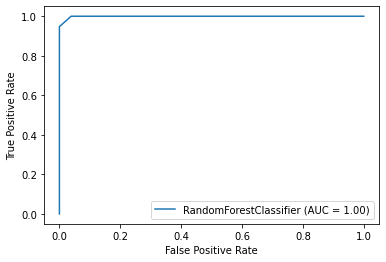

In [61]:
# Creating ROC Curve
from sklearn.metrics import plot_roc_curve
plot_roc_curve(clf, X_test, y_test);

In [62]:
# Display confusion matrix
print(confusion_matrix(y_test, y_pred))

[[25  1]
 [ 0 19]]


In [63]:
# Show classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.95      1.00      0.97        19

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



## Predictions for new Rock Glaciers 

In this step possible new rock glaciers' existence were tested.

Predictions with Random Forest

In [90]:
pd.options.display.float_format = '{:.2f}'.format

In [91]:
possibleRG

,X,Y,Altitude,Aspect,Curvature,LST,Slope,Solar_Radiation,SWE,Wetness,Class,Preds_RF
0,4502402.02,4941809.65,3172,2,2.15,19.25,29.84,1185717,-2,7.26,1,1
1,4404110.70,4785950.71,3044,2,1.54,16.80,20.11,1275672,-2,7.26,1,1
2,4402916.54,4785305.33,3076,2,0.31,21.15,11.33,1279381,-2,7.73,1,1
3,4411046.79,4789308.14,2938,8,2.31,21.97,19.28,1140627,-2,9.73,1,1
4,4417175.19,4792260.24,3047,1,0.77,17.56,14.20,1328728,-2,7.26,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
57,4400092.81,4789445.77,2733,1,-0.46,21.04,22.11,1306457,-2,5.50,1,0
58,4383500.45,4790982.51,2690,8,-0.31,20.37,23.96,1206074,-2,4.80,1,1
59,4370126.11,4794058.34,2827,2,0.15,21.83,13.97,1081565,-2,7.26,1,1
60,4364149.07,4794726.96,2642,3,-1.69,17.99,22.79,1254635,-2,7.55,1,1


In [65]:
# I prefer replace null values with the column mean
possibleRG.fillna(possibleRG.mean(), inplace=True)

In [66]:
yp = possibleRG["Class"]

In [67]:
Xp = possibleRG.drop('Class', axis=1)

In [68]:
yp = np.array(yp)

In [69]:
# Creating another dataframe for removing confusion
prg = possibleRG

In [70]:
c = pd.DataFrame({"Actual": yp, "Predictions_RF": clf.predict(Xp)})
prg["Preds_RF"] = clf.predict(Xp)

In [71]:
print(prg.to_string())

               X             Y  Altitude  Aspect  Curvature        LST      Slope  Solar_Radiation  SWE    Wetness  Class  Preds_RF
0   4.502402e+06  4.941810e+06      3172       2   2.152170  19.252899  29.842600          1185717   -2   7.258462      1         1
1   4.404111e+06  4.785951e+06      3044       2   1.537270  16.799900  20.108000          1275672   -2   7.258462      1         1
2   4.402917e+06  4.785305e+06      3076       2   0.307453  21.152300  11.332400          1279381   -2   7.733380      1         1
3   4.411047e+06  4.789308e+06      2938       8   2.305900  21.966700  19.277500          1140627   -2   9.725730      1         1
4   4.417175e+06  4.792260e+06      3047       1   0.768634  17.562599  14.201500          1328728   -2   7.258462      1         1
5   4.356525e+06  4.793151e+06      2858       8   0.614907  23.718399  46.537899          1115892   -2   9.956750      1         1
6   4.534618e+06  4.953609e+06      2996       1  -3.535710  17.938200   7.4

Predictions with Logistic Regression

In [72]:
#Creating Classifier
clf2=LogisticRegression()
#Fitting the model
clf2.fit(X_train,y_train)

y_pred2=clf2.predict(X_test)
# Accuracy test
print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))

Accuracy: 0.9333333333333333


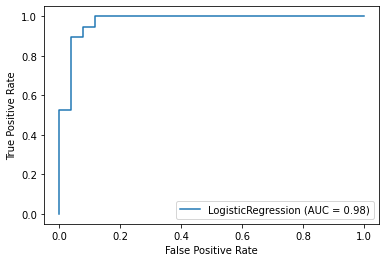

In [73]:
# Creating ROC Curve
from sklearn.metrics import plot_roc_curve
plot_roc_curve(clf2, X_test, y_test);

In [74]:
# Display confusion matrix
print(confusion_matrix(y_test, y_pred2))

[[24  2]
 [ 1 18]]


In [75]:
# Show classification report
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        26
           1       0.90      0.95      0.92        19

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.93        45
weighted avg       0.93      0.93      0.93        45



In [76]:
# Creating another dataframe for removing confusion
prl = possibleRG.drop(['Preds_RF'], axis=1)

In [77]:
c = pd.DataFrame({"Actual": yp, "Predictions_LR": clf2.predict(Xp)})
prl["Preds_LR"] = clf2.predict(Xp)

In [78]:
print(prl.to_string())

            X          Y  Altitude  Aspect  Curvature   LST  Slope  Solar_Radiation  SWE  Wetness  Class  Preds_LR
0  4502402.02 4941809.65      3172       2       2.15 19.25  29.84          1185717   -2     7.26      1         1
1  4404110.70 4785950.71      3044       2       1.54 16.80  20.11          1275672   -2     7.26      1         1
2  4402916.54 4785305.33      3076       2       0.31 21.15  11.33          1279381   -2     7.73      1         1
3  4411046.79 4789308.14      2938       8       2.31 21.97  19.28          1140627   -2     9.73      1         1
4  4417175.19 4792260.24      3047       1       0.77 17.56  14.20          1328728   -2     7.26      1         1
5  4356524.89 4793151.18      2858       8       0.61 23.72  46.54          1115892   -2     9.96      1         1
6  4534617.99 4953608.51      2996       1      -3.54 17.94   7.46           749752   -2     9.19      1         1
7  4535073.41 4953738.62      3012       7       0.00 20.19  16.26          1301

Predictions with tuned KNN

In [79]:
y_pred3=rs_log_reg.predict(X_test)
# Accuracy test
print("Accuracy:",metrics.accuracy_score(y_test, y_pred3))

Accuracy: 0.9333333333333333


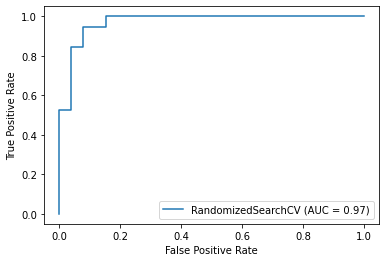

In [80]:
# Creating ROC Curve
from sklearn.metrics import plot_roc_curve
plot_roc_curve(rs_log_reg, X_test, y_test);

In [81]:
# Display confusion matrix
print(confusion_matrix(y_test, y_pred3))

[[24  2]
 [ 1 18]]


In [82]:
# Show classification report
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        26
           1       0.90      0.95      0.92        19

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.93        45
weighted avg       0.93      0.93      0.93        45



In [83]:
# Creating another dataframe for removing confusion
prk = possibleRG.drop(['Preds_RF'], axis=1)

In [84]:
c = pd.DataFrame({"Actual": yp, "Predictions_KNN": rs_log_reg.predict(Xp)})
prk["Preds_KNN"] = rs_log_reg.predict(Xp)

In [85]:
print(prk.to_string())

            X          Y  Altitude  Aspect  Curvature   LST  Slope  Solar_Radiation  SWE  Wetness  Class  Preds_KNN
0  4502402.02 4941809.65      3172       2       2.15 19.25  29.84          1185717   -2     7.26      1          1
1  4404110.70 4785950.71      3044       2       1.54 16.80  20.11          1275672   -2     7.26      1          1
2  4402916.54 4785305.33      3076       2       0.31 21.15  11.33          1279381   -2     7.73      1          1
3  4411046.79 4789308.14      2938       8       2.31 21.97  19.28          1140627   -2     9.73      1          1
4  4417175.19 4792260.24      3047       1       0.77 17.56  14.20          1328728   -2     7.26      1          1
5  4356524.89 4793151.18      2858       8       0.61 23.72  46.54          1115892   -2     9.96      1          1
6  4534617.99 4953608.51      2996       1      -3.54 17.94   7.46           749752   -2     9.19      1          1
7  4535073.41 4953738.62      3012       7       0.00 20.19  16.26      

In [88]:
data = [prk['X'], prk['Y'], prg['Preds_RF'],prl['Preds_LR'], prk['Preds_KNN']]

headers = ["X", "Y", "Preds_RF", "Preds_LR", "Preds_KNN"]
comparison = pd.concat(data, axis=1, keys=headers)

In [89]:
print(comparison.to_string())

            X          Y  Preds_RF  Preds_LR  Preds_KNN
0  4502402.02 4941809.65         1         1          1
1  4404110.70 4785950.71         1         1          1
2  4402916.54 4785305.33         1         1          1
3  4411046.79 4789308.14         1         1          1
4  4417175.19 4792260.24         1         1          1
5  4356524.89 4793151.18         1         1          1
6  4534617.99 4953608.51         1         1          1
7  4535073.41 4953738.62         1         1          1
8  4532979.55 4954394.53         0         0          0
9  4555421.97 4971577.36         1         1          1
10 4560141.21 4974120.03         1         1          1
11 4566917.01 4977833.61         0         0          0
12 4568669.15 4979808.29         1         0          0
13 4575677.73 4984933.07         1         0          0
14 4577026.51 4985257.51         1         0          0
15 4578740.20 4987378.12         1         1          1
16 4564314.86 4977734.38         1         1    